In [1]:
import subprocess
import json
import pickle

DEFAULT_ATTRIBUTES = (
    'index',
    'uuid',
    'name',
    'timestamp',
    'memory.total',
    'memory.free',
    'memory.used',
    'utilization.gpu',
    'utilization.memory'
)

def get_gpu_info(nvidia_smi_path='nvidia-smi', keys=DEFAULT_ATTRIBUTES, no_units=True):
    nu_opt = '' if not no_units else ',nounits'
    cmd = '%s --query-gpu=%s --format=csv,noheader%s' % (nvidia_smi_path, ','.join(keys), nu_opt)
    output = subprocess.check_output(cmd, shell=True)
    lines = output.decode().split('\n')
    lines = [ line.strip() for line in lines if line.strip() != '' ]

    return [ { k: v for k, v in zip(keys, line.split(', ')) } for line in lines ]


import pprint
pprint.pprint(get_gpu_info())

[{'index': '0',
  'memory.free': '22072',
  'memory.total': '24220',
  'memory.used': '2148',
  'name': 'Quadro RTX 6000',
  'timestamp': '2021/03/30 14:26:21.162',
  'utilization.gpu': '44',
  'utilization.memory': '21',
  'uuid': 'GPU-db966896-6737-76ef-eb8f-d1d3e708cf4c'},
 {'index': '1',
  'memory.free': '24217',
  'memory.total': '24220',
  'memory.used': '3',
  'name': 'Quadro RTX 6000',
  'timestamp': '2021/03/30 14:26:21.164',
  'utilization.gpu': '0',
  'utilization.memory': '0',
  'uuid': 'GPU-d2a975aa-48e6-2325-3322-c39f4c42fa53'}]


# Import

In [2]:
# !pip install pydicom

In [151]:
# !pip install python-gdcm

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 9.4 MB 15.0 MB/s eta 0:00:01
You should consider upgrading via the '/bin/python3 -m pip install --upgrade pip' command.


In [153]:
# !pip install pillow

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/bin/python3 -m pip install --upgrade pip' command.


In [2]:
!pip install ensemble-boxes

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/bin/python3 -m pip install --upgrade pip' command.


In [4]:
import sys
sys.path.insert(0, "Weighted-Boxes-Fusion")
import os
from PIL import Image
import pandas as pd
from tqdm.auto import tqdm
from ensemble_boxes import *

In [5]:
# !pip install --upgrade seaborn
!pip install -q iterative-stratification

You should consider upgrading via the '/bin/python3 -m pip install --upgrade pip' command.


In [6]:
import numpy as np, pandas as pd
from glob import glob
import shutil, os
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm
import seaborn as sns

import shutil as sh
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold


In [66]:
dim = 1536 #512, 256, 'original'
fold = 4

In [67]:
list_remove = [34843, 21125, 647, 18011, 2539, 22373, 12675, 7359, 20642, 5502, 19818, 5832, 28056, 28333, 20758,
               925, 43, 2199, 4610, 21306, 16677, 1768, 17232, 1378, 24949, 30203, 31410, 87, 25318, 92, 31724,
               118, 17687, 12605, 26157, 33875, 7000, 3730, 18776, 13225, 1109, 2161, 33627, 15500, 28633, 28152,
               10114, 10912, 9014,  4427, 25630, 11464, 6419, 22164, 4386, 17557, 15264, 21853, 33142, 32895, 9733,
               33010, 17493, 32128, 28802, 11658, 8841, 29557, 4802, 8591, 778, 9935, 12359, 5210, 7556, 24505, 5664,
               28670, 27820, 19359, 9817, 7800, 32934, 34098, 27931, 16074, 27308, 30645, 31029, 35697, 6199, 27065,
               1771, 14689, 31860, 1975, 29294, 2304, 34018, 23406, 26501, 26011, 2479, 32796, 25836, 3032, 31454,
               32066, 19722, 15997, 6049, 9458, 11005, 23151, 24503, 35411, 18092, 23815, 30742, 33942, 34542, 7655,
               25345, 3750, 17046, 3844, 5958, 4250, 18823, 14898, 22581, 25805, 9651, 33194, 36007, 30160, 24459,
               10838, 16544, 31252, 8053, 28487, 6208, 25244, 8470, 10089, 24813, 14769, 34305, 34047, 23366, 8049,
               13276, 22380, 32797, 32440, 11031, 18304, 33692, 21349, 26333, 34331, 9110, 21092, 34882, 35626, 10203,
               25648, 30754, 29567, 33542, 15146, 26759, 20846, 22493, 33187, 22813, 30219, 14548, 14627, 20494, 28332,
               15930, 31347, 33489, 35005, 34032, 24183, 18643, 18536, 29754, 20380, 29750, 20539, 35791, 27275, 32248]
image_remove = ['9c83d9f88170cd38f7bca54fe27dc48a', 'ac2a615b3861212f9a2ada6acd077fd9',
                'f9f7feefb4bac748ff7ad313e4a78906', 'f89143595274fa6016f6eec550442af9',
                '6c08a98e48ba72aee1b7b62e1f28e6da', 'e7a58f5647d24fc877f9cb3d051792e2',
                '8f98e3e6e86e573a6bd32403086b3707', '43d3137e74ebd344636228e786cb91b0',
                '575b98a9f9824d519937a776bd819cc4', 'ca6c1531a83f8ee89916ed934f8d4847',
                '0c6a7e3c733bd4f4d89443ca16615fc6', 'ae5cec1517ab3e82c5374e4c6219a17d',
                '064023f1ff95962a1eee46b9f05f7309', '27c831fee072b232499541b0aca58d9c',
                '0b98b21145a9425bf3eeea4b0de425e7', '7df5c81873c74ecc40610a1ad4eb2943']

In [68]:
train_df = pd.read_csv(f'./train_csv.csv')#何でもok
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2332,2580
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,2954,3159
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,2540,3072


In [69]:
train_df['image_path'] = f'/home/ubuntu/train_1280/train/'+train_df.image_id+('.png' if dim!='original' else '.jpg')
train_df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,image_path
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2332,2580,/home/ubuntu/train_1280/train/50a418190bc3fb1e...
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,2954,3159,/home/ubuntu/train_1280/train/21a10246a5ec7af1...
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336,/home/ubuntu/train_1280/train/9a5094b2563a1ef3...
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880,/home/ubuntu/train_1280/train/051132a778e61a86...
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,2540,3072,/home/ubuntu/train_1280/train/063319de25ce7edb...
...,...,...,...,...,...,...,...,...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN,2444,3200,/home/ubuntu/train_1280/train/936fd5cff1c058d3...
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN,1994,2430,/home/ubuntu/train_1280/train/ca7e72954550eeb6...
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN,2048,2500,/home/ubuntu/train_1280/train/aa17d5312a0fb4a2...
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,771.0,979.0,1680.0,1311.0,1968,2040,/home/ubuntu/train_1280/train/4b56bc6d22b192f0...


# Only 14 Class

In [70]:
train_df = train_df[train_df.class_id!=14].reset_index(drop = True)
train_df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,image_path
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336,/home/ubuntu/train_1280/train/9a5094b2563a1ef3...
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880,/home/ubuntu/train_1280/train/051132a778e61a86...
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0,2540,3072,/home/ubuntu/train_1280/train/1c32170b4af4ce1a...
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0,2285,2555,/home/ubuntu/train_1280/train/0c7a38f293d5f5e4...
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0,2568,3353,/home/ubuntu/train_1280/train/47ed17dcb2cbeec1...
...,...,...,...,...,...,...,...,...,...,...,...
36091,b53d1dd80e99ca6bcef9d592f65d3321,Pleural effusion,10,R9,240.0,1550.0,562.0,2001.0,2304,2880,/home/ubuntu/train_1280/train/b53d1dd80e99ca6b...
36092,26d1d5a0ef2e692c6340e74859ffdc53,Pulmonary fibrosis,13,R10,1163.0,787.0,1338.0,941.0,3072,3072,/home/ubuntu/train_1280/train/26d1d5a0ef2e692c...
36093,22672ab82c290c20b86863291e25ef6c,ILD,5,R9,299.0,664.0,794.0,1508.0,2048,2500,/home/ubuntu/train_1280/train/22672ab82c290c20...
36094,db169d0be36123bd55b866d6aa73983b,Other lesion,9,R8,6.0,670.0,272.0,1736.0,2304,2880,/home/ubuntu/train_1280/train/db169d0be36123bd...


# Pre-Processing

In [71]:
def label_resize(org_size, img_size, *bbox):
    x0, y0, x1, y1 = bbox
    x0_new = int(np.round(x0*img_size[1]/org_size[1]))#w 691.0*(1024/2080)
    y0_new = int(np.round(y0*img_size[0]/org_size[0]))#h
    x1_new = int(np.round(x1*img_size[1]/org_size[1]))
    y1_new = int(np.round(y1*img_size[0]/org_size[0]))
    return x0_new, y0_new, x1_new, y1_new

In [72]:
SIZE = 1536
IMG_SIZE = (SIZE, SIZE)

In [73]:
train_df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,image_path
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336,/home/ubuntu/train_1280/train/9a5094b2563a1ef3...
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880,/home/ubuntu/train_1280/train/051132a778e61a86...
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0,2540,3072,/home/ubuntu/train_1280/train/1c32170b4af4ce1a...
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0,2285,2555,/home/ubuntu/train_1280/train/0c7a38f293d5f5e4...
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0,2568,3353,/home/ubuntu/train_1280/train/47ed17dcb2cbeec1...
...,...,...,...,...,...,...,...,...,...,...,...
36091,b53d1dd80e99ca6bcef9d592f65d3321,Pleural effusion,10,R9,240.0,1550.0,562.0,2001.0,2304,2880,/home/ubuntu/train_1280/train/b53d1dd80e99ca6b...
36092,26d1d5a0ef2e692c6340e74859ffdc53,Pulmonary fibrosis,13,R10,1163.0,787.0,1338.0,941.0,3072,3072,/home/ubuntu/train_1280/train/26d1d5a0ef2e692c...
36093,22672ab82c290c20b86863291e25ef6c,ILD,5,R9,299.0,664.0,794.0,1508.0,2048,2500,/home/ubuntu/train_1280/train/22672ab82c290c20...
36094,db169d0be36123bd55b866d6aa73983b,Other lesion,9,R8,6.0,670.0,272.0,1736.0,2304,2880,/home/ubuntu/train_1280/train/db169d0be36123bd...


In [74]:
train_abnormal = train_df[train_df['class_name']!='No finding'].reset_index(drop=True)
train_abnormal[['x_min_resize', 'y_min_resize', 'x_max_resize', 'y_max_resize']] = train_abnormal \
.apply(lambda x: label_resize(x[['height', 'width']].values, IMG_SIZE, *x[['x_min', 'y_min', 'x_max', 'y_max']].values),
       axis=1, result_type="expand")
train_abnormal['x_center'] = 0.5*(train_abnormal['x_min_resize'] + train_abnormal['x_max_resize'])
train_abnormal['y_center'] = 0.5*(train_abnormal['y_min_resize'] + train_abnormal['y_max_resize'])
train_abnormal['width'] = train_abnormal['x_max_resize'] - train_abnormal['x_min_resize']
train_abnormal['height'] = train_abnormal['y_max_resize'] - train_abnormal['y_min_resize']
train_abnormal['area'] = train_abnormal.apply(lambda x: (x['x_max_resize']-x['x_min_resize'])*(x['y_max_resize']-x['y_min_resize']), axis=1)
train_abnormal = train_abnormal[~train_abnormal.index.isin(list_remove)].reset_index(drop=True)

train_abnormal.tail()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,image_path,x_min_resize,y_min_resize,x_max_resize,y_max_resize,x_center,y_center,area
35894,b53d1dd80e99ca6bcef9d592f65d3321,Pleural effusion,10,R9,240.0,1550.0,562.0,2001.0,215,240,/home/ubuntu/train_1280/train/b53d1dd80e99ca6b...,160,827,375,1067,267.5,947.0,51600
35895,26d1d5a0ef2e692c6340e74859ffdc53,Pulmonary fibrosis,13,R10,1163.0,787.0,1338.0,941.0,87,76,/home/ubuntu/train_1280/train/26d1d5a0ef2e692c...,582,394,669,470,625.5,432.0,6612
35896,22672ab82c290c20b86863291e25ef6c,ILD,5,R9,299.0,664.0,794.0,1508.0,372,519,/home/ubuntu/train_1280/train/22672ab82c290c20...,224,408,596,927,410.0,667.5,193068
35897,db169d0be36123bd55b866d6aa73983b,Other lesion,9,R8,6.0,670.0,272.0,1736.0,177,569,/home/ubuntu/train_1280/train/db169d0be36123bd...,4,357,181,926,92.5,641.5,100713
35898,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,771.0,979.0,1680.0,1311.0,709,250,/home/ubuntu/train_1280/train/4b56bc6d22b192f0...,602,737,1311,987,956.5,862.0,177250


In [75]:
def Preprocess_wbf(df, size=SIZE, iou_thr=0.5, skip_box_thr=0.0001):
    list_image = []
    list_boxes = []
    list_cls = []
    list_h, list_w = [], []
    new_df = pd.DataFrame()
    for image_id in tqdm(df['image_id'].unique(), leave=False):
        image_df = df[df['image_id']==image_id].reset_index(drop=True)
        h, w = image_df.loc[0, ['height', 'width']].values
        boxes = image_df[['x_min_resize', 'y_min_resize',
                          'x_max_resize', 'y_max_resize']].values.tolist()
        boxes = [[j/(size-1) for j in i] for i in boxes]
        scores = [1.0]*len(boxes)
        labels = [float(i) for i in image_df['class_id'].values]
        boxes, scores, labels = weighted_boxes_fusion([boxes], [scores], [labels],
                                                      weights=None,
                                                      iou_thr=iou_thr,
                                                      skip_box_thr=skip_box_thr)
        list_image.extend([image_id]*len(boxes))
        list_h.extend([h]*len(boxes))
        list_w.extend([w]*len(boxes))
        list_boxes.extend(boxes)
        list_cls.extend(labels.tolist())
    list_boxes = [[int(j*(size-1)) for j in i] for i in list_boxes]
    new_df['image_id'] = list_image
    new_df['class_id'] = list_cls
    new_df['height'] = list_h
    new_df['width'] = list_w
    new_df['x_min_resize'], new_df['y_min_resize'], \
    new_df['x_max_resize'], new_df['y_max_resize'] = np.transpose(list_boxes)
    new_df['x_center'] = 0.5*(new_df['x_min_resize'] + new_df['x_max_resize'])
    new_df['y_center'] = 0.5*(new_df['y_min_resize'] + new_df['y_max_resize'])
    new_df['width'] = new_df['x_max_resize'] - new_df['x_min_resize']
    new_df['height'] = new_df['y_max_resize'] - new_df['y_min_resize']
    new_df['area'] = new_df.apply(lambda x: (x['x_max_resize']-x['x_min_resize'])\
                                  *(x['y_max_resize']-x['y_min_resize']), axis=1)
    return new_df

train_abnormal = Preprocess_wbf(train_abnormal)
print(len(train_abnormal))
train_abnormal.tail()

/home/ubuntu/.local/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:85: UserWarning: Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
/home/ubuntu/.local/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')


23763


,image_id,class_id,height,width,x_min_resize,y_min_resize,x_max_resize,y_max_resize,x_center,y_center,area
23758,be53fe5a49231f1c1be020b0bdd8561f,6.0,91,151,295,587,446,678,370.5,632.5,13741
23759,380d07a94cc4b012812119370de47192,0.0,171,200,864,427,1064,598,964.0,512.5,34200
23760,52951d7de2485aba8ed62629eee4d254,9.0,36,52,202,768,254,804,228.0,786.0,1872
23761,52951d7de2485aba8ed62629eee4d254,3.0,161,596,481,860,1077,1021,779.0,940.5,95956
23762,1224f07d895107573588225f692e94f9,0.0,192,185,773,471,958,663,865.5,567.0,35520


# Fold

In [76]:
def split_df(df):
    kf = MultilabelStratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    df['id'] = df.index
    annot_pivot = pd.pivot_table(df, index=['image_id'], columns=['class_id'],
                                 values='id', fill_value=0, aggfunc='count') \
    .reset_index().rename_axis(None, axis=1)
    for fold, (train_idx, val_idx) in enumerate(kf.split(annot_pivot,
                                                         annot_pivot.iloc[:, 1:(1+df['class_id'].nunique())])):
        annot_pivot[f'fold_{fold}'] = 0
        annot_pivot.loc[val_idx, f'fold_{fold}'] = 1
    return annot_pivot

size_df = pd.read_csv('./train_meta.csv')
size_df.columns = ['image_id', 'h', 'w']

fold_csv = split_df(train_abnormal)
fold_csv = fold_csv.merge(size_df, on='image_id', how='left')
fold_csv.head(10)

,image_id,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,...,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,fold_9,h,w
0,0005e8e3701dfb1dd93d53e2ff537b6e,0,0,0,0,1,0,1,1,1,...,0,0,0,0,0,0,0,1,3072,3072
1,0007d316f756b3fa0baea2ff514ce945,1,0,0,1,0,2,0,0,0,...,0,0,0,0,0,0,0,0,2880,2304
2,000d68e42b71d3eac10ccc077aba07c1,1,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,2880,2304
3,00150343289f317a0ad5629d5b7d9ef9,2,0,0,1,0,0,0,2,0,...,0,0,0,1,0,0,0,0,2508,2525
4,001d127bad87592efe45a5c7678f8b8d,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3072,3072
5,0046f681f078851293c4e710c4466058,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,2880,2304
6,0061cf6d35e253b6e7f03940592cc35e,1,0,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,3072,2540
7,00675cd546313f912cadd4ad54415d69,1,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,2992,2606
8,008b3176a7248a0a189b5731ac8d2e95,0,0,0,1,0,0,0,3,4,...,1,0,0,0,0,0,0,0,3147,2505
9,009d4c31ebf87e51c5c8c160a4bd8006,1,0,0,0,1,0,0,3,0,...,0,0,0,1,0,0,0,0,2890,2762


# Create Dataset

In [77]:
mkdir nms_chest_yolo_1536

In [78]:
SIZE

1536

In [80]:
#trainとvalidにfolderを分ける
#最終的には全foldで
def create_file(df, split_df, train_file, train_folder, fold):
    
    os.makedirs(f'{train_file}/labels/train/', exist_ok=True)
    os.makedirs(f'{train_file}/images/train/', exist_ok=True)
    os.makedirs(f'{train_file}/labels/val/', exist_ok=True)
    os.makedirs(f'{train_file}/images/val/', exist_ok=True)
    
    list_image_train = split_df[split_df[f'fold_{fold}']==0]['image_id']    
#     train_df = df[df['image_id'].isin(list_image_train)].reset_index(drop=True)
    train_df = df.reset_index(drop=True)
    print(len(train_df))
    val_df = df[~df['image_id'].isin(list_image_train)].reset_index(drop=True)
    
    for train_img in tqdm(train_df.image_id.unique()):
        with open(f'{train_file}/labels/train/{train_img}.txt', 'w+') as f:
            row = train_df[train_df['image_id']==train_img]\
            [['class_id', 'x_center', 'y_center', 'width', 'height']].values
            row[:, 1:] /= SIZE
            row = row.astype('str')
            for box in range(len(row)):
                text = ' '.join(row[box])
                f.write(text)
                f.write('\n')
        sh.copy(f'{train_folder}/{train_img}.png', 
                f'{train_file}/images/train/{train_img}.png')
        
    for val_img in tqdm(val_df.image_id.unique()):
        with open(f'{train_file}/labels/val/{val_img}.txt', 'w+') as f:
            row = val_df[val_df['image_id']==val_img]\
            [['class_id', 'x_center', 'y_center', 'width', 'height']].values
            row[:, 1:] /= SIZE
            row = row.astype('str')
            for box in range(len(row)):
                text = ' '.join(row[box])
                f.write(text)
                f.write('\n')
        sh.copy(f'{train_folder}/{val_img}.png', 
                f'{train_file}/images/val/{val_img}.png')
        
create_file(train_abnormal, fold_csv, './all_nms_chest_yolo_1536', './train_1536/train', 0)


23763


# Get Class Name

In [81]:
class_ids, class_names = list(zip(*set(zip(train_df.class_id, train_df.class_name))))
classes = list(np.array(class_names)[np.argsort(class_ids)])
classes = list(map(lambda x: str(x), classes))
classes

['Aortic enlargement',
 'Atelectasis',
 'Calcification',
 'Cardiomegaly',
 'Consolidation',
 'ILD',
 'Infiltration',
 'Lung Opacity',
 'Nodule/Mass',
 'Other lesion',
 'Pleural effusion',
 'Pleural thickening',
 'Pneumothorax',
 'Pulmonary fibrosis']

In [89]:
from os import listdir
from os.path import isfile, join
import yaml

#fold10_evi
cwd = '/home/ubuntu/'

#pathを作成(.txt)
with open(join( cwd , 'all_train_nms_1536_10fold.txt'), 'w') as f:
    for path in glob('/home/ubuntu/all_nms_chest_yolo_1536/images/train/*'):
        f.write(path+'\n')
            
with open(join( cwd , 'all_val_nms_1536_10fold.txt'), 'w') as f:
    for path in glob('/home/ubuntu/all_nms_chest_yolo_1536/images/val/*'):
        f.write(path+'\n')

data = dict(
    train =  join( cwd , 'all_train_nms_1536_10fold.txt') ,
    val   =  join( cwd , 'all_val_nms_1536_10fold.txt' ),
    nc    = 14,
    names = classes
    )


with open(join( cwd , 'all_vinbigdata_nms_1536_10fold.yaml'), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

f = open(join( cwd , 'all_vinbigdata_nms_1536_10fold.yaml'), 'r')
print('\nyaml:')
print(f.read())


yaml:
names:
- Aortic enlargement
- Atelectasis
- Calcification
- Cardiomegaly
- Consolidation
- ILD
- Infiltration
- Lung Opacity
- Nodule/Mass
- Other lesion
- Pleural effusion
- Pleural thickening
- Pneumothorax
- Pulmonary fibrosis
nc: 14
train: /home/ubuntu/all_train_nms_1536_10fold.txt
val: /home/ubuntu/all_val_nms_1536_10fold.txt



In [90]:
# https://www.kaggle.com/ultralytics/yolov5
# !git clone https://github.com/ultralytics/yolov5  # clone repo
# %cd yolov5
# shutil.copytree('/kaggle/input/yolov5-official-v31-dataset/yolov5', '/kaggle/working/yolov5')
os.chdir('./yolov5')
# %pip install -qr requirements.txt # install dependencies

import torch
from IPython.display import Image, clear_output  # to display images

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.8.1+cu102 _CudaDeviceProperties(name='Quadro RTX 6000', major=7, minor=5, total_memory=24220MB, multi_processor_count=72)


## Pretrained Checkpoints:

| Model | AP<sup>val</sup> | AP<sup>test</sup> | AP<sub>50</sub> | Speed<sub>GPU</sub> | FPS<sub>GPU</sub> || params | FLOPS |
|---------- |------ |------ |------ | -------- | ------| ------ |------  |  :------: |
| [YOLOv5s](https://github.com/ultralytics/yolov5/releases/tag/v3.0)    | 37.0     | 37.0     | 56.2     | **2.4ms** | **416** || 7.5M   | 13.2B
| [YOLOv5m](https://github.com/ultralytics/yolov5/releases/tag/v3.0)    | 44.3     | 44.3     | 63.2     | 3.4ms     | 294     || 21.8M  | 39.4B
| [YOLOv5l](https://github.com/ultralytics/yolov5/releases/tag/v3.0)    | 47.7     | 47.7     | 66.5     | 4.4ms     | 227     || 47.8M  | 88.1B
| [YOLOv5x](https://github.com/ultralytics/yolov5/releases/tag/v3.0)    | **49.2** | **49.2** | **67.7** | 6.9ms     | 145     || 89.0M  | 166.4B
| | | | | | || |
| [YOLOv5x](https://github.com/ultralytics/yolov5/releases/tag/v3.0) + TTA|**50.8**| **50.8** | **68.9** | 25.5ms    | 39      || 89.0M  | 354.3B
| | | | | | || |
| [YOLOv3-SPP](https://github.com/ultralytics/yolov5/releases/tag/v3.0) | 45.6     | 45.5     | 65.2     | 4.5ms     | 222     || 63.0M  | 118.0B

# Selecting Models
In this notebok I'm using `v5s`. To select your prefered model just replace `--cfg models/yolov5s.yaml --weights yolov5s.pt` with the following command:
* `v5s` : `--cfg models/yolov5s.yaml --weights yolov5s.pt`
* `v5m` : `--cfg models/yolov5m.yaml --weights yolov5m.pt`
* `v5l` : `--cfg models/yolov5l.yaml --weights yolov5l.pt`
* `v5x` : `--cfg models/yolov5x.yaml --weights yolov5x.pt`

# Train

In [85]:
!pip install -U PyYAML

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: PyYAML in /home/ubuntu/.local/lib/python3.8/site-packages (5.4.1)
You should consider upgrading via the '/bin/python3 -m pip install --upgrade pip' command.


In [86]:
!pip install -q yolov5 

You should consider upgrading via the '/bin/python3 -m pip install --upgrade pip' command.


In [91]:
#2
!python -m torch.distributed.launch --nproc_per_node 2 train.py --batch-size 8 --img 1536 --epochs 40 --name 'exp36fix1536_allfold_anchors3_anchor_t3_augfixed_yolov5l6.pt_40epo_1536' --data '/home/ubuntu/all_vinbigdata_nms_1536_10fold.yaml' --hyp '/home/ubuntu/yolov5/data/hyp.scratch.yaml' --weights yolov5l6.pt #--cache


*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
*****************************************
github: ⚠️ WARNING: code is out of date by 6 commits. Use 'git pull' to update or 'git clone https://github.com/ultralytics/yolov5' to download latest.
YOLOv5 🚀 v4.0-168-g2bf34f5 torch 1.8.1+cu102 CUDA:0 (Quadro RTX 6000, 24220.3125MB)
                                             CUDA:1 (Quadro RTX 6000, 24220.3125MB)

Added key: store_based_barrier_key:1 to store for rank: 0
Namespace(adam=False, artifact_alias='latest', batch_size=4, bbox_interval=-1, bucket='', cache_images=False, cfg='', data='/home/ubuntu/all_vinbigdata_nms_1536_10fold.yaml', device='', entity=None, epochs=40, evolve=False, exist_ok=False, global_rank=0, hyp='/home/ubuntu/yolov5/data/hyp.scratch.yaml', image_weights=False, im

# Class Distribution

In [ ]:
# plt.figure(figsize = (20,20))
# plt.axis('off')
# plt.imshow(plt.imread('runs/train/exp2/labels_correlogram.jpg'));

In [ ]:
# plt.figure(figsize = (20,20))
# plt.axis('off')
# plt.imshow(plt.imread('runs/train/exp2/labels.jpg'));

# Batch Image

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15, 15))
plt.imshow(plt.imread('runs/train/exp11_augtrain_anc_th4_yolov5l.pt_30epo_1_10fold/train_batch0.jpg'))

plt.figure(figsize = (15, 15))
plt.imshow(plt.imread('runs/train/exp11_augtrain_anc_th4_yolov5l.pt_30epo_1_10fold/train_batch1.jpg'))

plt.figure(figsize = (15, 15))
plt.imshow(plt.imread('runs/train/exp11_augtrain_anc_th4_yolov5l.pt_30epo_1_10fold/train_batch2.jpg'))

# GT Vs Pred

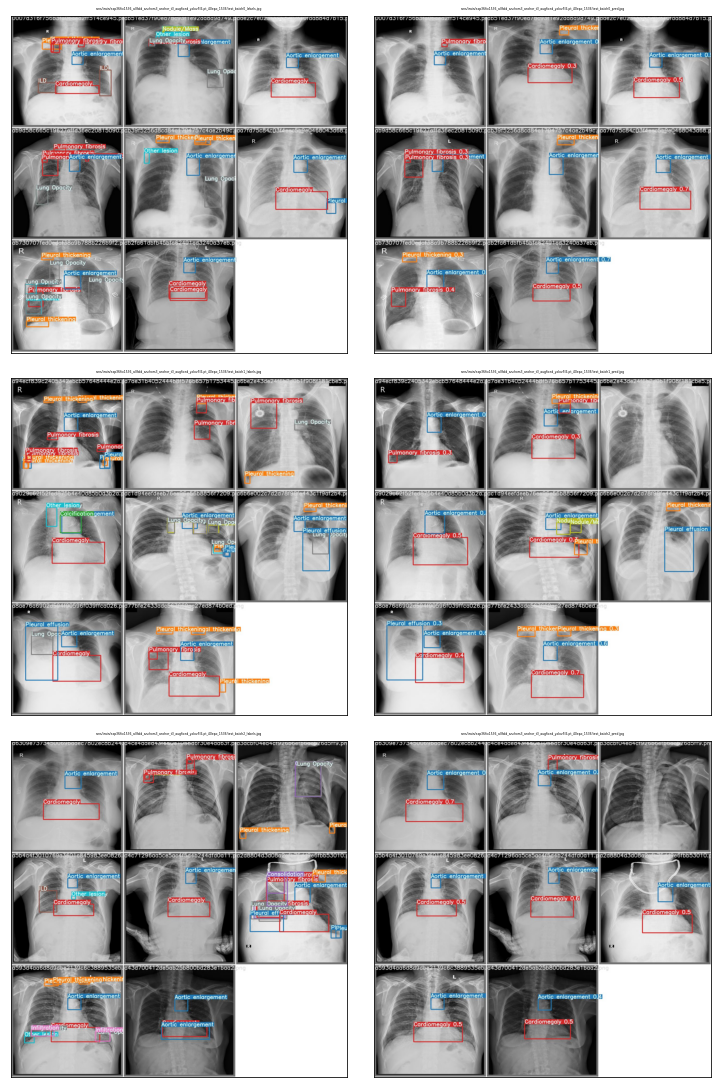

In [93]:
fig, ax = plt.subplots(3, 2, figsize = (2*5,3*5), constrained_layout = True)
train_path = 'exp36fix1536_allfold_anchors3_anchor_t3_augfixed_yolov5l6.pt_40epo_1536'
for row in range(3):
    ax[row][0].imshow(plt.imread(f'runs/train/{train_path}/test_batch{row}_labels.jpg'))
    ax[row][0].set_xticks([])
    ax[row][0].set_yticks([])
    ax[row][0].set_title(f'runs/train/{train_path}/test_batch{row}_labels.jpg', fontsize = 3)
    
    ax[row][1].imshow(plt.imread(f'runs/train/{train_path}/test_batch{row}_pred.jpg'))
    ax[row][1].set_xticks([])
    ax[row][1].set_yticks([])
    ax[row][1].set_title(f'runs/train/{train_path}/test_batch{row}_pred.jpg', fontsize = 3)

# (Loss, Map) Vs Epoch

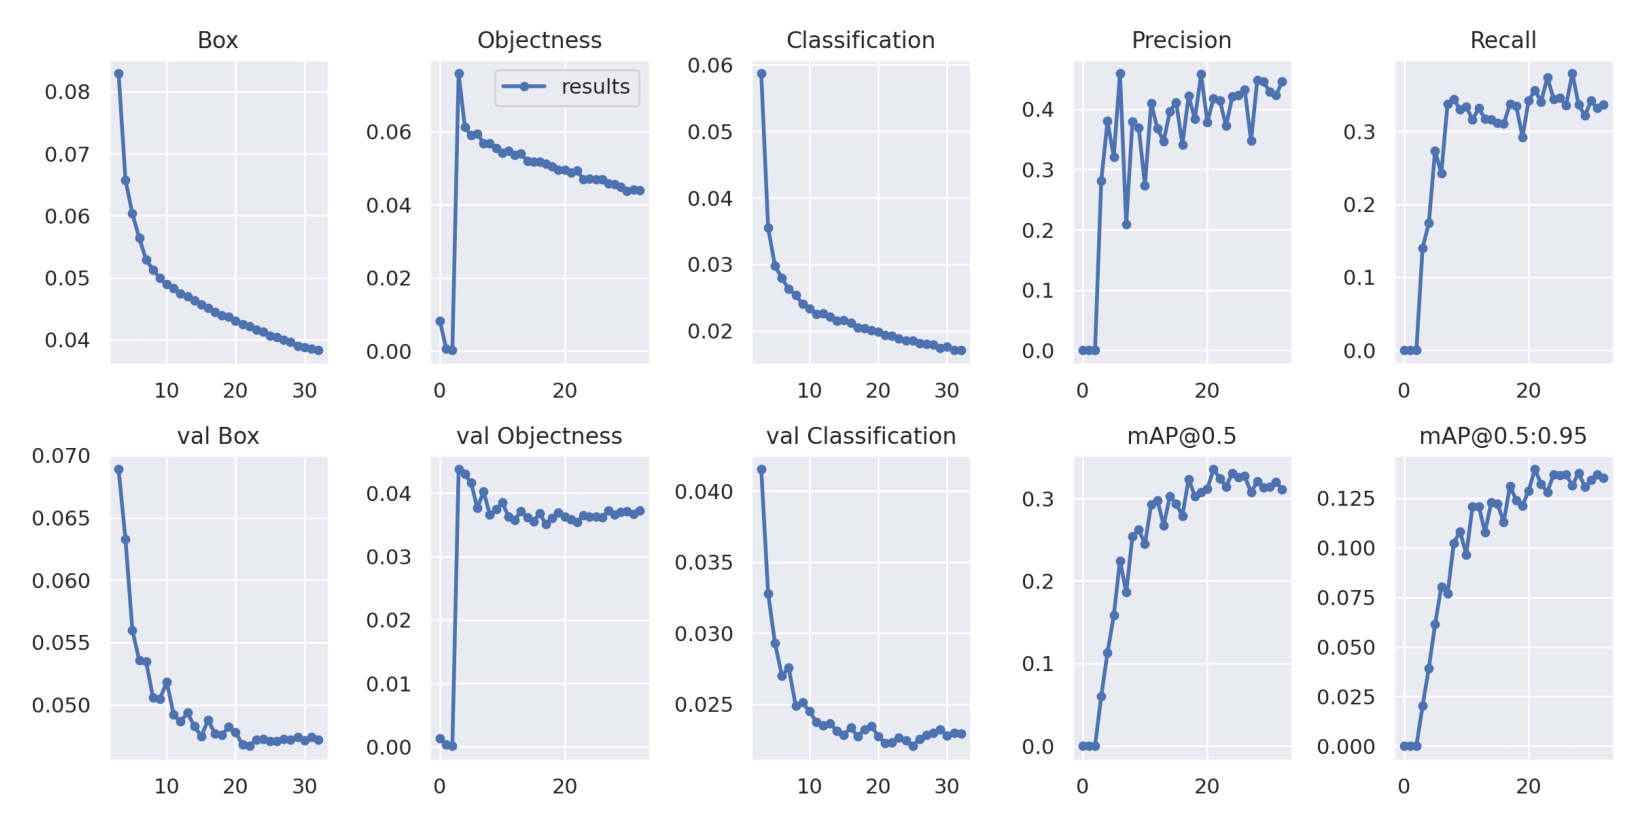

In [ ]:
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp5_yolov5l.pt_1024_30epo_10fold2/results.png'));

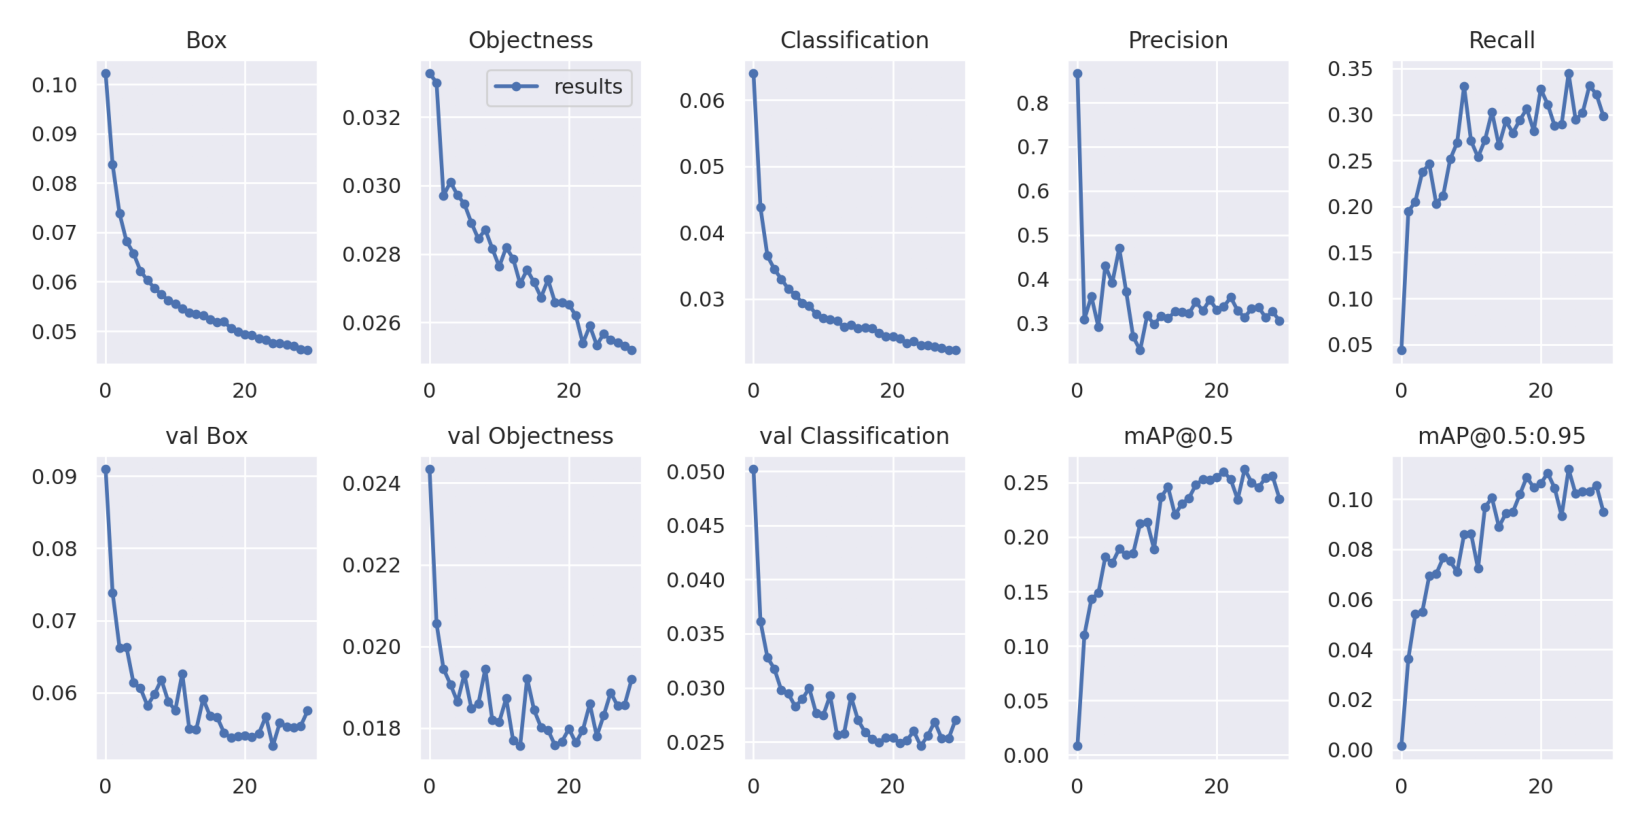

In [ ]:
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp/results.png'));

# Confusion Matrix

In [ ]:
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp/confusion_matrix.png'));

# inference

In [20]:
# https://www.kaggle.com/ultralytics/yolov5
# !git clone https://github.com/ultralytics/yolov5  # clone repo
# %cd yolov5
# shutil.copytree('/kaggle/input/yolov5-official-v31-dataset/yolov5', '/kaggle/working/yolov5')
os.chdir('./yolov5')
# %pip install -qr requirements.txt # install dependencies

import torch
from IPython.display import Image, clear_output  # to display images

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.8.1+cu102 _CudaDeviceProperties(name='Quadro RTX 6000', major=7, minor=5, total_memory=24220MB, multi_processor_count=72)


In [21]:
!pip install -U PyYAML
!pip install -q yolov5 

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: PyYAML in /home/ubuntu/.local/lib/python3.8/site-packages (5.4.1)
You should consider upgrading via the '/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/bin/python3 -m pip install --upgrade pip' command.


In [22]:
# !python detect.py --weights 'runs/train/exp35fix1408_allfold_anchors3_anchor_t3_augfixed_yolov5l6.pt_40epo_1408/weights/best.pt' \
# --img 1408 \
# --conf 0.0001 \
# --iou 0.4 \
# --augment \
# --source '/home/ubuntu/train_1408/test' \
# --name 'exp43_ens_35_1408' \
# --save-txt --save-conf --exist-ok

In [96]:
# !python detect.py --weights 'runs/train/exp36fix1536_allfold_anchors3_anchor_t3_augfixed_yolov5l6.pt_40epo_1536/weights/best.pt' \
# --img 1536 \
# --conf 0.0001 \
# --iou 0.4 \
# --augment \
# --source '/home/ubuntu/train_1536/test' \
# --name 'exp42_ens_36_1536' \
# --save-txt --save-conf --exist-ok

In [95]:
# !python detect.py --weights 'runs/train/exp32_allfold_anchors3_anchor_t3_augfixed_yolov5x6.pt_40epo_12802/weights/best.pt' 'runs/train/exp31_allfold_anchors3_anchor_t3_augfixed_yolov5l6.pt_40epo_12802/weights/best.pt' \
# --img 1280 \
# --conf 0.0001 \
# --iou 0.4 \
# --augment \
# --source '/home/ubuntu/train_1280/test' \
# --name 'exp41_ens_31_32' \
# --save-txt --save-conf --exist-ok

In [7]:
##########################################################################
test_meta_df = pd.read_csv(f'/home/ubuntu/test_meta.csv')
test_meta_df = test_meta_df.rename(columns={'dim0': 'height', 'dim1': 'width'})
test_meta_df.head()

,image_id,height,width
0,8dec5497ecc246766acfba5a4be4e619,2430,1994
1,287422bed1d9d153387361889619abed,2836,2336
2,1d12b94b7acbeadef7d7700b50aa90d4,2706,2492
3,6b872791e23742f6c33a08fc24f77365,2500,2048
4,d0d2addff91ad7beb1d92126ff74d621,2836,2336


In [8]:
sample_submission_df = pd.read_csv(f'/home/ubuntu/sample_submission.csv')

In [9]:
test_df = pd.merge(sample_submission_df,test_meta_df,on='image_id')
test_df.head()

,image_id,PredictionString,height,width
0,002a34c58c5b758217ed1f584ccbcfe9,14 1 0 0 1 1,2584,2345
1,004f33259ee4aef671c2b95d54e4be68,14 1 0 0 1 1,3028,2517
2,008bdde2af2462e86fd373a445d0f4cd,14 1 0 0 1 1,2880,2304
3,009bc039326338823ca3aa84381f17f1,14 1 0 0 1 1,2430,1994
4,00a2145de1886cb9eb88869c85d74080,14 1 0 0 1 1,2408,2136


In [10]:
test_df = test_df.drop(columns=['PredictionString'])

In [11]:
test_df

,image_id,height,width
0,002a34c58c5b758217ed1f584ccbcfe9,2584,2345
1,004f33259ee4aef671c2b95d54e4be68,3028,2517
2,008bdde2af2462e86fd373a445d0f4cd,2880,2304
3,009bc039326338823ca3aa84381f17f1,2430,1994
4,00a2145de1886cb9eb88869c85d74080,2408,2136
...,...,...,...
2995,ff91fb82429a27521bbec8569b041f02,3072,3072
2996,ff9fcc4087ed5e941209aa3fa948e364,2880,2304
2997,ffaa288c8abca300974f043b57d81521,2958,2684
2998,ffc441e0c8b7153844047483a577e7c3,2328,1944


In [12]:
test_df[test_df['image_id']=='002a34c58c5b758217ed1f584ccbcfe9']

,image_id,height,width
0,002a34c58c5b758217ed1f584ccbcfe9,2584,2345


In [13]:
test_meta_df[test_meta_df['image_id']=='002a34c58c5b758217ed1f584ccbcfe9']

,image_id,height,width
1546,002a34c58c5b758217ed1f584ccbcfe9,2584,2345


# Post-processing

In [14]:
def yolo2voc(image_height, image_width, bboxes):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    voc  => [x1, y1, x2, y1]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]* image_height
    
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    bboxes[..., [2, 3]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]
    
    return bboxes

In [15]:
# pred_2class = pd.read_csv(inputdir/"vinbigdata-2class-prediction/2-cls test pred.csv")  # LB 0.230
# low_threshold = 0.0
# high_threshold = 0.95

pred_2class = pd.read_csv('/home/ubuntu/2-cls test pred.csv')
low_threshold = 0.001
high_threshold = 1
pred_2class

,image_id,target
0,002a34c58c5b758217ed1f584ccbcfe9,0.013326
1,004f33259ee4aef671c2b95d54e4be68,0.037235
2,008bdde2af2462e86fd373a445d0f4cd,0.939700
3,009bc039326338823ca3aa84381f17f1,0.123799
4,00a2145de1886cb9eb88869c85d74080,0.654006
...,...,...
2995,ff91fb82429a27521bbec8569b041f02,0.936325
2996,ff9fcc4087ed5e941209aa3fa948e364,0.963583
2997,ffaa288c8abca300974f043b57d81521,0.178720
2998,ffc441e0c8b7153844047483a577e7c3,0.225196


In [106]:
image_ids = []
PredictionStrings = []
#ちゃんとpredした順番になっているか？test_df
for file_path in tqdm(glob('runs/detect/exp43_ens_35_1408/labels/*txt')):#<====================
    image_id = file_path.split('/')[-1].split('.')[0]
    w, h = test_df.loc[test_df.image_id==image_id,['width', 'height']].values[0]
    f = open(file_path, 'r')
    data = np.array(f.read().replace('\n', ' ').strip().split(' ')).astype(np.float32).reshape(-1, 6)
    data = data[:, [0, 5, 1, 2, 3, 4]]
    bboxes = list((np.concatenate((data[:, :2], np.round(yolo2voc(h, w, data[:, 2:]))), axis =1).reshape(-1)).astype(str))
    # print(bboxes)
    for idx in range(len(bboxes)):
        bboxes[idx] = str(int(float(bboxes[idx]))) if idx%6!=1 else bboxes[idx]
    image_ids.append(image_id)
    PredictionStrings.append(' '.join(bboxes))
    # break

In [95]:
pred_df = pd.DataFrame({'image_id':image_ids,
                        'PredictionString':PredictionStrings})
sub_df = pd.merge(test_df, pred_df, on = 'image_id', how = 'left').fillna("14 1 0 0 1 1")
sub_df = sub_df[['image_id', 'PredictionString']]

OUTPUT_DIR = '/home/ubuntu/sub_folder/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# exp = '2_1024_yolov5l'
# sub_df.to_csv(f'{OUTPUT_DIR}/exp{exp}_submission.csv',index = False)
# sub_df.tail()

In [107]:
test_df

,image_id,height,width
0,002a34c58c5b758217ed1f584ccbcfe9,2584,2345
1,004f33259ee4aef671c2b95d54e4be68,3028,2517
2,008bdde2af2462e86fd373a445d0f4cd,2880,2304
3,009bc039326338823ca3aa84381f17f1,2430,1994
4,00a2145de1886cb9eb88869c85d74080,2408,2136
...,...,...,...
2995,ff91fb82429a27521bbec8569b041f02,3072,3072
2996,ff9fcc4087ed5e941209aa3fa948e364,2880,2304
2997,ffaa288c8abca300974f043b57d81521,2958,2684
2998,ffc441e0c8b7153844047483a577e7c3,2328,1944


In [98]:
pred_df

,image_id,PredictionString
0,02425334e92510da663eb913ad0632ea,8 0.004055019933730364 1348 1016 1402 1056 3 0...
1,32b33ed354f4f86cec0a90e53f584d58,9 0.004833220038563013 654 2015 877 2212 11 0....
2,0c6036df3708fe77c1c76498240d6774,3 0.006286620162427425 0 0 901 497 9 0.0062866...
3,781b722e178a483b4781fbd148706b7d,0 0.005191800184547901 1224 592 1517 971 8 0.0...
4,6c28ef5c6b6bc382a9c5b70fbe7f1864,8 0.004741670098155737 1475 410 1862 545 9 0.0...
...,...,...
2995,6325ed4ab3c3d0233263c751e7452907,0 0.007949830032885075 1203 614 1756 1307 9 0....
2996,e77218455b3b041a85732d4718eab319,11 0.004074099939316511 1501 31 1763 218 11 0....
2997,415bbe6901d71d5065322601c47544df,12 0.003944400232285261 654 1484 913 1883 9 0....
2998,2e585169bb0b0f7f6e4875b517f87259,8 0.011055000126361847 1411 1506 1575 1750 10 ...


In [99]:
# NORMAL = "14 1 0 0 1 1"

# # pred_det_df = pd.read_csv(inputdir/"vinbigdata-detectron2-prediction/results/20210125_all_alb_aug_512_cos/submission.csv")  # You can load from another submission.csv here too.
# pred_det_df = sub_df.copy()
# n_normal_before = len(pred_det_df.query("PredictionString == @NORMAL"))
# merged_df = pd.merge(pred_det_df, pred_2class, on="image_id", how="left")

# 1. p < low_threshold                   -> "Keep": Do nothing, Keep det prediction.
# 2. low_threshold <= p < high_threshold -> "Add": Just "Add" Normal prediction
# 3. high_threshold <= p                 -> "Replace": Replace with Normal prediction

# if "target" in merged_df.columns:
#     merged_df["class0"] = 1 - merged_df["target"]

# c0, c1, c2 = 0, 0, 0
# for i in range(len(merged_df)):
#     p0 = merged_df.loc[i, "class0"]
#     if p0 < low_threshold:
#         # Keep, do nothing.
#         c0 += 1
#     elif low_threshold <= p0 and p0 < high_threshold:
#         # Add, keep "det" preds and add normal pred.
#         merged_df.loc[i, "PredictionString"] += f" 14 {p0} 0 0 1 1"
#         c1 += 1
#     else:
#         # Replace, remove all "det" preds.
#         merged_df.loc[i, "PredictionString"] = NORMAL
#         c2 += 1

# n_normal_after = len(merged_df.query("PredictionString == @NORMAL"))
# print(
#     f"n_normal: {n_normal_before} -> {n_normal_after} with threshold {low_threshold} & {high_threshold}"
# )
# print(f"Keep {c0} Add {c1} Replace {c2}")
# # submission_filepath = str(outdir / "submission.csv")
# submission_df = merged_df[["image_id", "PredictionString"]]
# submission_df.to_csv(submission_filepath, index=False)

submission_df = sub_df.copy()
submission_df

exp = 'exp43_ens_35_1408_iou04'#<============================================!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


submission_df.to_csv(f'{OUTPUT_DIR}/{exp}_submission.csv',index = False)
print(f'Saved to {OUTPUT_DIR}{exp}_submission.csv')

Saved to /home/ubuntu/sub_folder/exp42_ens_36_1536_iou04_submission.csv


In [100]:
def label_resize_view(org_size, img_size, *bbox):#org_size [2430, 1994] x,y
    x0, y0, x1, y1 = bbox

    x0_new = int(np.round(x0*img_size[1]/org_size[1])) 
    y0_new = int(np.round(y0*img_size[0]/org_size[0]))
    x1_new = int(np.round(x1*img_size[1]/org_size[1]))
    y1_new = int(np.round(y1*img_size[0]/org_size[0]))
    return x0_new, y0_new, x1_new, y1_new

In [101]:
view_df = pd.read_csv('/home/ubuntu/sub_folder/exp42_ens_36_1536_iou04_submission.csv')

In [102]:
IMG_SIZE = (1280,1280)

In [103]:
predict_box_dcn = view_df.copy()
predict_box_dcn.head()

,image_id,PredictionString
0,002a34c58c5b758217ed1f584ccbcfe9,11 0.004638670012354851 2166 1667 2240 1835 2 ...
1,004f33259ee4aef671c2b95d54e4be68,2 0.0038566600997000933 1393 327 1622 410 13 0...
2,008bdde2af2462e86fd373a445d0f4cd,11 0.00436019990593195 1472 480 1754 859 10 0....
3,009bc039326338823ca3aa84381f17f1,3 0.008941650390625 659 1145 1602 1585 10 0.00...
4,00a2145de1886cb9eb88869c85d74080,8 0.0038204200100153685 2004 1054 2051 1107 2 ...


In [104]:
def make_list(cls_nb):
  bboxes = ['']
  if len(cls_nb) >0:
    for idx in range(len(list(np.concatenate(cls_nb)))):
      if idx%6!=1:
        bboxes[0] = bboxes[0] + ' ' + (str(list(np.concatenate(cls_nb).astype(int))[idx]))
      else:
        bboxes[0] = bboxes[0] + ' ' + (str(list(np.concatenate(cls_nb))[idx]))
  bboxes = bboxes[0][1:]
  return bboxes
  

In [60]:
# Aortic Enlargement (CLASS-ID: 0)
# Atelectasis (CLASS-ID: 1)
# Calcification (CLASS-ID: 2)
# Cardiomegaly (CLASS-ID: 3)
# Consolidation (CLASS-ID: 4)
# ILD (CLASS-ID: 5)
# Infiltration (CLASS-ID: 6)
# Lung Opacity (CLASS-ID: 7)
# Nodule/Mass (CLASS-ID: 8)
# Other Lesion (CLASS-ID: 9)
# Pleural Effusion (CLASS-ID: 10)
# Pleural Thickening (CLASS-ID: 11)
# Pneumothorax (CLASS-ID: 12)
# Pulmonary Fibrosis (CLASS-ID: 13)
# No Tissue Present (CLASS-ID: 14)

In [ ]:
sample_df = pd.read_csv('/home/ubuntu/sample_submission.csv')
sample_df = sample_df[['image_id']]

sub1 = pd.read_csv('/home/ubuntu/sub_folder/exp43_ens_35_1408_iou04_submission.csv')
sub2 = pd.read_csv('/home/ubuntu/sub_folder/exp42_ens_36_1536_iou04_submission.csv')
sub3 = pd.read_csv('/home/ubuntu/sub_folder/exp41_ens_31_32_1280_iou04_submission.csv')

In [140]:
PredictionStrings_ = []
rownum = 0
for rownum, row in sub3.iterrows():

  row_list = row['PredictionString']
  row_array = np.array(row_list.split(' ')).astype(np.float32).reshape(-1, 6)


  #---------max---------#
  # class_0_thr = [2]
  # class_1_thr = [4]
  # class_2_thr = [11]
  # class_3_thr = [2]
  # class_4_thr = [4]
  # class_5_thr = [3]
  # class_6_thr = [4]
  # class_7_thr = [9]
  # class_8_thr = [28]
  # class_9_thr = [12]
  # class_10_thr = [2]
  # class_11_thr = [7]
  # class_12_thr = [4]
  # class_13_thr = [7]
  #---------max---------#
  class_0_thr = [6]
  class_1_thr = [6]
  class_2_thr = [11]
  class_3_thr = [6]
  class_4_thr = [6]
  class_5_thr = [6]
  class_6_thr = [6]
  class_7_thr = [9]
  class_8_thr = [28]
  class_9_thr = [12]
  class_10_thr = [6]
  class_11_thr = [7]
  class_12_thr = [6]
  class_13_thr = [7]

  class_0 = []
  class_1 = []
  class_2 = []
  class_3 = []
  class_4 = []
  class_5 = []
  class_6 = []
  class_7 = []
  class_8 = []
  class_9 = []
  class_10 = []
  class_11 = []
  class_12 = []
  class_13 = []
  class_14 = []


  class_0_ct = 0
  class_1_ct = 0
  class_2_ct = 0
  class_3_ct = 0
  class_4_ct = 0
  class_5_ct = 0
  class_6_ct = 0
  class_7_ct = 0
  class_8_ct = 0
  class_9_ct = 0
  class_10_ct = 0
  class_11_ct = 0
  class_12_ct = 0
  class_13_ct = 0
  class_14_ct = 0

  class_all = ['']

  for bboxs in row_array:
    if bboxs[0] == 0:
      class_0_ct += 1
      class_0.append(bboxs)

    #~~~~~~~~~~~~~~~~~~~~~
    if bboxs[0] == 1:
      class_1_ct += 1
      class_1.append(bboxs)
    #~~~~~~~~~~~~~~~~~~~~~
    if bboxs[0] == 2:
      class_2_ct += 1
      class_2.append(bboxs)
    #~~~~~~~~~~~~~~~~~~~~~
    if bboxs[0] == 3:
      class_3_ct += 1
      class_3.append(bboxs)
    #~~~~~~~~~~~~~~~~~~~~~
    if bboxs[0] == 4:
      class_4_ct += 1
      class_4.append(bboxs)
    #~~~~~~~~~~~~~~~~~~~~~
    if bboxs[0] == 5:
      class_5_ct += 1
      class_5.append(bboxs)
    #~~~~~~~~~~~~~~~~~~~~~
    if bboxs[0] == 6:
      class_6_ct += 1
      class_6.append(bboxs)
    #~~~~~~~~~~~~~~~~~~~~~
    if bboxs[0] == 7:
      class_7_ct += 1
      class_7.append(bboxs)
    #~~~~~~~~~~~~~~~~~~~~~
    if bboxs[0] == 8:
      class_8_ct += 1
      class_8.append(bboxs)
    #~~~~~~~~~~~~~~~~~~~~~
    if bboxs[0] == 9:
      class_9_ct += 1
      class_9.append(bboxs)
    #~~~~~~~~~~~~~~~~~~~~~
    if bboxs[0] == 10:
      class_10_ct += 1
      class_10.append(bboxs)
    #~~~~~~~~~~~~~~~~~~~~~
    if bboxs[0] == 11:
      class_11_ct += 1
      class_11.append(bboxs)
    #~~~~~~~~~~~~~~~~~~~~~
    if bboxs[0] == 12:
      class_12_ct += 1
      class_12.append(bboxs)
    #~~~~~~~~~~~~~~~~~~~~~
    if bboxs[0] == 13:
      class_13_ct += 1
      class_13.append(bboxs)
    #~~~~~~~~~~~~~~~~~~~~~
    if bboxs[0] == 14:
      class_14_ct += 1
      class_14.append(bboxs)

  num_ct = (class_0_ct + class_1_ct + class_2_ct + class_3_ct + class_4_ct + \
      class_5_ct + class_6_ct + class_7_ct + class_8_ct + class_9_ct + \
      class_10_ct + class_11_ct + class_12_ct + class_13_ct + class_14_ct)
   
  ##########################
  if len(class_0) > class_0_thr[0]:
    class_0 = class_0[:class_0_thr[0]]

  if len(class_1) > class_1_thr[0]:
    class_1 = class_1[:class_1_thr[0]]

  if len(class_2) > class_2_thr[0]:
    class_2 = class_2[:class_2_thr[0]]

  if len(class_3) > class_3_thr[0]:
    class_3 = class_3[:class_3_thr[0]]

  if len(class_4) > class_4_thr[0]:
    class_4 = class_4[:class_4_thr[0]]
  
  if len(class_5) > class_5_thr[0]:
    class_5 = class_5[:class_5_thr[0]]
  
  if len(class_6) > class_6_thr[0]:
    class_6 = class_6[:class_6_thr[0]]
  
  if len(class_7) > class_7_thr[0]:
    class_7 = class_7[:class_7_thr[0]]
  
  if len(class_8) > class_8_thr[0]:
    class_8 = class_8[:class_8_thr[0]]

  if len(class_9) > class_9_thr[0]:
    class_9 = class_9[:class_9_thr[0]]

  if len(class_10) > class_10_thr[0]:
    
    class_10 = class_10[:class_10_thr[0]]
    
  
  if len(class_11) > class_11_thr[0]:
    class_11 = class_11[:class_11_thr[0]]

  if len(class_12) > class_12_thr[0]:
    class_12 = class_12[:class_12_thr[0]]

  if len(class_13) > class_13_thr[0]:
    class_13 = class_13[:class_13_thr[0]]
  ##########################
  bboxes = make_list(class_0)
  if len(bboxes) > 0:
    class_all[0] = class_all[0] +' '+bboxes

  bboxes = make_list(class_1)
  if len(bboxes) > 0:
    class_all[0] = class_all[0] +' '+bboxes
  
  bboxes = make_list(class_2)
  if len(bboxes) > 0:
    class_all[0] = class_all[0] +' '+bboxes

  bboxes = make_list(class_３)
  if len(bboxes) > 0:
    class_all[0] = class_all[0] +' '+bboxes

  bboxes = make_list(class_4)
  if len(bboxes) > 0:
    class_all[0] = class_all[0] +' '+bboxes

  bboxes = make_list(class_5)
  if len(bboxes) > 0:
    class_all[0] = class_all[0] +' '+bboxes
  
  bboxes = make_list(class_6)
  if len(bboxes) > 0:
    class_all[0] = class_all[0] +' '+bboxes

  bboxes = make_list(class_7)
  if len(bboxes) > 0:
    class_all[0] = class_all[0] +' '+bboxes

  bboxes = make_list(class_8)
  if len(bboxes) > 0:
    class_all[0] = class_all[0] +' '+bboxes
  
  bboxes = make_list(class_9)
  if len(bboxes) > 0:
    class_all[0] = class_all[0] +' '+bboxes

  bboxes = make_list(class_10)
  if len(bboxes) > 0:
    class_all[0] = class_all[0] +' '+bboxes

  bboxes = make_list(class_11)
  if len(bboxes) > 0:
    class_all[0] = class_all[0] +' '+bboxes

  bboxes = make_list(class_12)
  if len(bboxes) > 0:
    class_all[0] = class_all[0] +' '+bboxes

  bboxes = make_list(class_13)
  if len(bboxes) > 0:
    class_all[0] = class_all[0] +' '+bboxes 
 
  bboxes = make_list(class_14)
  if len(bboxes) > 0:
    class_all[0] = class_all[0]+' '+bboxes 
  #########################class_all = class_all[0][1:]だけ必要かも
  if ((class_0_ct + class_1_ct + class_2_ct + class_3_ct + class_4_ct + \
      class_5_ct + class_6_ct + class_7_ct + class_8_ct + class_9_ct + \
      class_10_ct + class_11_ct + class_12_ct + class_13_ct + class_14_ct) == 1 ):
        class_all = class_all[0][1:]#最初の' 'を削除
  else:
    class_all = class_all[0][1:]



#   print(f'rownum={rownum},num_ct={num_ct},')
  PredictionStrings_.append(class_all)

  rownum += 1
  # if rownum == 50:
  #   break

In [141]:
pred_df = pd.DataFrame({'image_id':predict_box_dcn['image_id'],
                        'PredictionString':PredictionStrings_})
sub_df_cut = pred_df[['image_id', 'PredictionString']]

In [142]:
sub_df_cut.to_csv('/home/ubuntu/sub_folder/cut_exp41_ens_31_32_1280_iou04_submission.csv')

In [143]:
sub_df_cut

,image_id,PredictionString
0,002a34c58c5b758217ed1f584ccbcfe9,0 0.0060463 1341 6 1612 137 0 0.00631714 1416 ...
1,004f33259ee4aef671c2b95d54e4be68,0 0.00516891 783 334 1062 407 0 0.00552368 128...
2,008bdde2af2462e86fd373a445d0f4cd,0 0.00538635 1775 2290 1906 2533 0 0.00543976 ...
3,009bc039326338823ca3aa84381f17f1,0 0.0170441 79 1650 332 1976 0 0.0236969 201 6...
4,00a2145de1886cb9eb88869c85d74080,0 0.00534058 1238 348 1502 431 0 0.0057869 198...
...,...,...
2995,ff91fb82429a27521bbec8569b041f02,0 0.00790405 0 0 250 250 0 0.00801086 115 0 59...
2996,ff9fcc4087ed5e941209aa3fa948e364,0 0.00871277 886 599 1039 884 0 0.00904846 2 2...
2997,ffaa288c8abca300974f043b57d81521,0 0.0138931 1294 654 1617 1047 0 0.0141602 148...
2998,ffc441e0c8b7153844047483a577e7c3,0 0.00416946 2 997 111 1479 0 0.00421906 580 1...


In [ ]:
import random
import cv2
import matplotlib.patches as patches


def list_color(class_list):
    dict_color = dict()
    for classid in class_list:
        dict_color[classid] = [i/256 for i in random.sample(range(256), 3)]
    
    return dict_color

def display_image_test(df, size_df, list_image, num_image=3):
    
    dict_color = list_color(range(15))
    image_row_random = np.random.choice(len(df), num_image, replace=(len(df)<num_image))
    for image_idx in image_row_random:
        image_id, pred = df.loc[image_idx, 'image_id'], df.loc[image_idx, 'PredictionString']
        org_size = size_df[size_df['image_id']==image_id][['h', 'w']].values[0].tolist()
        fig, ax = plt.subplots(1, figsize=(15, 15))
        img_path = [i for i in list_image if image_id in i][0]
        img = cv2.imread(img_path)
        ax.imshow(img, plt.cm.bone)
        if pred != '14 1.0 0 0 1 1':
            list_pred = pred.split(' ')
            for box_idx in range(len(list_pred)//6)[:-1]:
                bbox = map(int, list_pred[6*box_idx+2:6*box_idx+6])
                x_min, y_min, x_max, y_max = label_resize_view(org_size, IMG_SIZE, *bbox)
                class_name, score = int(list_pred[6*box_idx]), float(list_pred[6*box_idx+1])
                rect = patches.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min,
                                         linewidth=1, edgecolor=dict_color[class_name], facecolor='none')
                ax.add_patch(rect)
                plt.text(x_min, y_min, f'{class_name}: {score}', fontsize=15, color='red')            

        plt.title(image_id) 
        plt.show()

# size_df = pd.read_csv(TEST_META_PATH)
size_df = test_df.copy()
size_df.columns = ['image_id', 'h', 'w']
test_list = glob(f'/home/ubuntu/train_1280/test/*.png')

image_abnormal = view_df[view_df['PredictionString']!='14 1.0 0 0 1 1'].reset_index(drop=True)
display_image_test(image_abnormal, size_df, test_list, num_image=20)

# ens

In [114]:
from ensemble_boxes import *

boxes_list = [[
    [0.00, 0.51, 0.81, 0.91],
    [0.10, 0.31, 0.71, 0.61],
    [0.01, 0.32, 0.83, 0.93],
    [0.02, 0.53, 0.11, 0.94],
    [0.03, 0.24, 0.12, 0.35],
],[
    [0.04, 0.56, 0.84, 0.92],
    [0.12, 0.33, 0.72, 0.64],
    [0.38, 0.66, 0.79, 0.95],
    [0.08, 0.49, 0.21, 0.89],
]]
scores_list = [[0.9, 0.8, 0.2, 0.4, 0.7], [0.5, 0.8, 0.7, 0.3]]
labels_list = [[0, 1, 0, 1, 1], [1, 1, 1, 0]]
weights = [2, 1]

iou_thr = 0.5
skip_box_thr = 0.0001
sigma = 0.1

boxes, scores, labels = nms(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr)
boxes, scores, labels = soft_nms(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, sigma=sigma, thresh=skip_box_thr)
boxes, scores, labels = non_maximum_weighted(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
boxes, scores, labels = weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr)

In [144]:
##########################################################################
test_meta_df = pd.read_csv(f'/home/ubuntu/test_meta.csv')
test_meta_df = test_meta_df.rename(columns={'dim0': 'height', 'dim1': 'width'})#<=====================fixed
test_meta_df.head()

sample_submission_df = pd.read_csv(f'/home/ubuntu/sample_submission.csv')

test_df = pd.merge(sample_submission_df,test_meta_df,on='image_id')
test_df = test_df[['image_id','height','width']]
test_df.head()

,image_id,height,width
0,002a34c58c5b758217ed1f584ccbcfe9,2584,2345
1,004f33259ee4aef671c2b95d54e4be68,3028,2517
2,008bdde2af2462e86fd373a445d0f4cd,2880,2304
3,009bc039326338823ca3aa84381f17f1,2430,1994
4,00a2145de1886cb9eb88869c85d74080,2408,2136


In [145]:
sample_df = pd.read_csv('/home/ubuntu/sample_submission.csv')
sample_df = sample_df[['image_id']]

sub1 = pd.read_csv('/home/ubuntu/sub_folder/cut_exp43_ens_35_1408_iou04_submission.csv')
sub2 = pd.read_csv('/home/ubuntu/sub_folder/cut_exp42_ens_36_1536_iou04_submission.csv')
sub3 = pd.read_csv('/home/ubuntu/sub_folder/cut_exp41_ens_31_32_1280_iou04_submission.csv')

In [147]:
df_list = [sub1['PredictionString'],sub2['PredictionString'],sub3['PredictionString']]

In [148]:
def Label_Normalization(org_size, bbox):#org_size [2430, 1994] w,h
    x0, y0, x1, y1 = bbox

    x0_new = (x0/org_size[0]) 
    y0_new = (y0/org_size[1])
    x1_new = (x1/org_size[0])
    y1_new = (y1/org_size[1])
    return [x0_new, y0_new, x1_new, y1_new]

In [149]:
def Label_motoni(org_size, bbox):#org_size [2430, 1994] [w,h]
    x0, y0, x1, y1 = bbox

    x0_new = int(np.round(x0*org_size[0]))
    y0_new = int(np.round(y0*org_size[1]))
    x1_new = int(np.round(x1*org_size[0]))
    y1_new = int(np.round(y1*org_size[1]))
    return [x0_new, y0_new, x1_new, y1_new]

In [150]:
def make_list(cls_nb):
  bboxes = ['']
  if len(cls_nb) >0:
    for idx in range(len(list(np.concatenate(cls_nb)))):
      if idx%6!=1:
        bboxes[0] = bboxes[0] + ' ' + (str(list(np.concatenate(cls_nb).astype(int))[idx]))
      else:
        bboxes[0] = bboxes[0] + ' ' + (str(list(np.concatenate(cls_nb))[idx]))
  bboxes = bboxes[0][1:]
  return bboxes

In [ ]:
 #14 は　最後にすること

mode = 'nms' #'nms','weighted_boxes_fusion'
count = 0

boxes_list = []
scores_list = []
labels_list = []

ensed_list = []

weights = [1, 1 ,1]

iou_thr = 0.5#小さい程、box減る
skip_box_thr = 0.0001
sigma = 0.1
for idx in range(3000):
  print(idx)
  #ens row
  labels_list_ens = []
  scores_list_ens = []
  boxes_list_ens = []
  #正規化の為
  image_height = test_df['height'][idx]
  image_width = test_df['width'][idx]
  org_size=[image_width,image_height]
  # org_size=[image_height,image_width]#h,w
  

  for df_nb,row in enumerate(df_list):#ens dfs

    row_list = row[idx]
    
    # print(np.array(row_list.split(' ')).reshape(-1, 6))
    row_array = np.array(row_list.split(' ')).reshape(-1, 6)

    labels_list_1 = []
    scores_list_1 = []
    boxes_list_1 = []
    for row_array_1 in (row_array):
      labels_list_1.append(row_array_1[0].astype(int).tolist())
      scores_list_1.append(row_array_1[1].astype(np.float32).tolist())
      
      if row_array_1[2].astype(int)>= org_size[0]:# w?>=h
        print('org_size',org_size,'idx',idx,'df_nb',df_nb)
        print(row_array_1[2].astype(int),org_size[0])
      if row_array_1[5].astype(int)>= org_size[1]:
        print('org_size',org_size,'idx',idx,'df_nb',df_nb)
        print(row_array_1[5].astype(int),org_size[1])

      # if row_array_1[5].astype(int)>= org_size[0]:
      #   print('org_size',org_size,'idx',idx,'df_nb',df_nb)
      #   print(row_array_1[5].astype(int),org_size[0])
      # if row_array_1[2].astype(int)>= org_size[1]: #w > h
      #   print('org_size',org_size,'idx',idx,'df_nb',df_nb)
      #   print(row_array_1[2].astype(int),org_size[1])#w > h
      
      boxes_norm = Label_Normalization(org_size,row_array_1[2:6].astype(int))

      boxes_list_1.append(boxes_norm)
      
    labels_list_ens.append(labels_list_1)
    scores_list_ens.append(scores_list_1)
    boxes_list_ens.append(boxes_list_1)
  # print('scores_list_ens',scores_list_ens)
  # print('labels_list_ens',labels_list_ens)
  # print('boxes_list_ens',boxes_list_ens)
  
  if mode == 'nms':
    boxes, scores, labels = nms(boxes_list_ens, scores_list_ens, labels_list_ens, weights=weights, iou_thr=iou_thr)
  if mode == 'weighted_boxes_fusion':
    boxes, scores, labels = weighted_boxes_fusion(boxes_list_ens, scores_list_ens, labels_list_ens, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
  

  boxes_ = []
  #元のサイズに戻す
  for box in boxes:
    boxes_.append(Label_motoni(org_size,box))
  # print('after boxes', boxes_)

  # print('labels',labels)
  # print('len==========',len(labels))
  # print('~~~~~')

  labels = labels.astype(int)
  ensed_arr = np.stack([labels,scores],1)
  ensed_arr = np.hstack([ensed_arr,boxes_])
  box_6 = make_list(ensed_arr)
  

  ensed_list.append(box_6)


  # count +=1
  # if count == 3:
  #   break

In [152]:
last_pred_df = pd.DataFrame({'image_id':test_df['image_id'],
                        'PredictionString':ensed_list})
last_sub_df = last_pred_df[['image_id', 'PredictionString']]

In [153]:
last_sub_df

,image_id,PredictionString
0,002a34c58c5b758217ed1f584ccbcfe9,0 0.0024693800757328668 1282 264 1656 432 0 0....
1,004f33259ee4aef671c2b95d54e4be68,0 0.002185819980998834 1382 317 1666 414 0 0.0...
2,008bdde2af2462e86fd373a445d0f4cd,0 0.0019391366901497047 1573 896 1733 1170 0 0...
3,009bc039326338823ca3aa84381f17f1,0 0.15299466252326965 981 467 1218 744 0 0.044...
4,00a2145de1886cb9eb88869c85d74080,0 0.0022010800118247667 1557 1911 1861 2242 0 ...
...,...,...
2995,ff91fb82429a27521bbec8569b041f02,0 0.002766926772892475 934 586 1214 835 0 0.00...
2996,ff9fcc4087ed5e941209aa3fa948e364,0 0.003936766646802425 2048 2761 2304 2880 0 0...
2997,ffaa288c8abca300974f043b57d81521,0 0.010467533022165298 1889 1588 2347 2147 0 0...
2998,ffc441e0c8b7153844047483a577e7c3,0 0.0016682933395107586 377 276 768 626 0 0.00...


In [154]:
# pred_2class = pd.read_csv(inputdir/"vinbigdata-2class-prediction/2-cls test pred.csv")  # LB 0.230
# low_threshold = 0.0
# high_threshold = 0.95

pred_2class = pd.read_csv('/home/ubuntu/2-cls test pred.csv')
low_threshold = 0.001
high_threshold = 0.976#0.97
pred_2class

,image_id,target
0,002a34c58c5b758217ed1f584ccbcfe9,0.013326
1,004f33259ee4aef671c2b95d54e4be68,0.037235
2,008bdde2af2462e86fd373a445d0f4cd,0.939700
3,009bc039326338823ca3aa84381f17f1,0.123799
4,00a2145de1886cb9eb88869c85d74080,0.654006
...,...,...
2995,ff91fb82429a27521bbec8569b041f02,0.936325
2996,ff9fcc4087ed5e941209aa3fa948e364,0.963583
2997,ffaa288c8abca300974f043b57d81521,0.178720
2998,ffc441e0c8b7153844047483a577e7c3,0.225196


In [155]:
NORMAL = "14 1 0 0 1 1"

# pred_det_df = pd.read_csv(inputdir/"vinbigdata-detectron2-prediction/results/20210125_all_alb_aug_512_cos/submission.csv")  # You can load from another submission.csv here too.
pred_det_df = last_sub_df.copy()
n_normal_before = len(pred_det_df.query("PredictionString == @NORMAL"))
merged_df = pd.merge(pred_det_df, pred_2class, on="image_id", how="left")

# 1. p < low_threshold

# -> "Keep": Do nothing, Keep det prediction.
# 2. low_threshold <= p < high_threshold -> "Add": Just "Add" Normal prediction
# 3. high_threshold <= p                 -> "Replace": Replace with Normal prediction

if "target" in merged_df.columns:
    merged_df["class0"] = 1 - merged_df["target"]

c0, c1, c2 = 0, 0, 0
for i in range(len(merged_df)):
    p0 = merged_df.loc[i, "class0"]
    if p0 < low_threshold:
        # Keep, do nothing.
        c0 += 1
    elif low_threshold <= p0 and p0 < high_threshold:
        # Add, keep "det" preds and add normal pred.
        merged_df.loc[i, "PredictionString"] += f" 14 {p0} 0 0 1 1"
        c1 += 1
    else:
        # Replace, remove all "det" preds.
        merged_df.loc[i, "PredictionString"] = NORMAL
        c2 += 1

n_normal_after = len(merged_df.query("PredictionString == @NORMAL"))
print(
    f"n_normal: {n_normal_before} -> {n_normal_after} with threshold {low_threshold} & {high_threshold}"
)
print(f"Keep {c0} Add {c1} Replace {c2}")
# submission_filepath = str(outdir / "submission.csv")
submission_df = merged_df[["image_id", "PredictionString"]]
# submission_df.to_csv(submission_filepath, index=False)

# submission_df = sub_df.copy()
# submission_df

exp = 'last_sub_2class_ens_thr0973'#<============================================!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


submission_df.to_csv(f'{OUTPUT_DIR}/{exp}_submission.csv',index = False)
print(f'Saved to {OUTPUT_DIR}{exp}_submission.csv')

n_normal: 0 -> 1285 with threshold 0.001 & 0.976
Keep 0 Add 1715 Replace 1285
Saved to /home/ubuntu/sub_folder/last_sub_2class_ens_thr0973_submission.csv


In [157]:
submission_df.head(50)

,image_id,PredictionString
0,002a34c58c5b758217ed1f584ccbcfe9,14 1 0 0 1 1
1,004f33259ee4aef671c2b95d54e4be68,0 0.002185819980998834 1382 317 1666 414 0 0.0...
2,008bdde2af2462e86fd373a445d0f4cd,0 0.0019391366901497047 1573 896 1733 1170 0 0...
3,009bc039326338823ca3aa84381f17f1,0 0.15299466252326965 981 467 1218 744 0 0.044...
4,00a2145de1886cb9eb88869c85d74080,0 0.0022010800118247667 1557 1911 1861 2242 0 ...
5,00b7e6bfa4dc1fe9ddd0ce74743e38c2,0 0.004280099955697854 1104 565 1481 1711 0 0....
6,011295e0bcdc7636569ab73bfdcc4450,14 1 0 0 1 1
7,013c169f9dad6f1f6485da961b9f7bf2,0 0.00442760003109773 1270 1713 1576 2103 0 0....
8,01431a2618c0ace741e4e270a37e20b9,0 0.0021947232695917287 0 0 104 176 0 0.002184...
9,0168eb925aa6f28a78b16134792f5d0e,14 1 0 0 1 1
